In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Read Data Set

In [52]:
segmentations = pd.read_csv("data/train_ship_segmentations_v2.csv")
segmentations['EncodedPixels'] = segmentations['EncodedPixels'].astype('string')

# Feature Extraction¶

In [53]:
def get_train_image(name: str):
    path = f'data/train_v2/{name}'
    return cv2.imread(path)

def extract_features_from_image(row: pd.Series) -> pd.Series:
    image = np.zeros((768, 768, 3))# get_train_image(row['ImageId'])
    row['ImageHeight'], row['ImageWidth'], _ = image.shape
    return row

segmentations = segmentations.apply(lambda x: extract_features_from_image(x), axis=1)

# Corrupted images¶

In [54]:
corrupted_images = ['6384c3e78.jpg']
segmentations[segmentations['ImageId'].isin(corrupted_images)]

,ImageId,EncodedPixels,ImageHeight,ImageWidth
90158,6384c3e78.jpg,<NA>,768,768


In [55]:
segmentations = segmentations.drop(segmentations[segmentations['ImageId'].isin(corrupted_images)].index)
segmentations[segmentations['ImageId'].isin(corrupted_images)]

,ImageId,EncodedPixels,ImageHeight,ImageWidth


# Exploring the data

In [56]:
print(f'There are {segmentations.shape[0]} rows.')
segmentations.head(10)

There are 231722 rows.


,ImageId,EncodedPixels,ImageHeight,ImageWidth
0,00003e153.jpg,<NA>,768,768
1,0001124c7.jpg,<NA>,768,768
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768,768
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768,768
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,768,768
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,768,768
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,768,768
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,768,768
8,0001b1832.jpg,<NA>,768,768
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,768,768


In [57]:
train_images_number = segmentations['ImageId'].nunique()
print(f'There are {train_images_number} train images.')

There are 192555 train images.


In [58]:
print(segmentations['ImageHeight'].value_counts())
print(segmentations['ImageWidth'].value_counts())

ImageHeight
768    231722
Name: count, dtype: int64
ImageWidth
768    231722
Name: count, dtype: int64


# Distribution of the number of ships in images

In [59]:
images_without_ships = segmentations['EncodedPixels'].isna().sum()
print(f'There are {images_without_ships} images without ships.')

There are 149999 images without ships.


ShipCount
0            149999
1             27104
2              7674
3              2954
4              1622
5               925
6               657
7               406
8               318
9               243
10              168
11              144
12              124
14               76
13               75
15               66
Name: count, dtype: int64


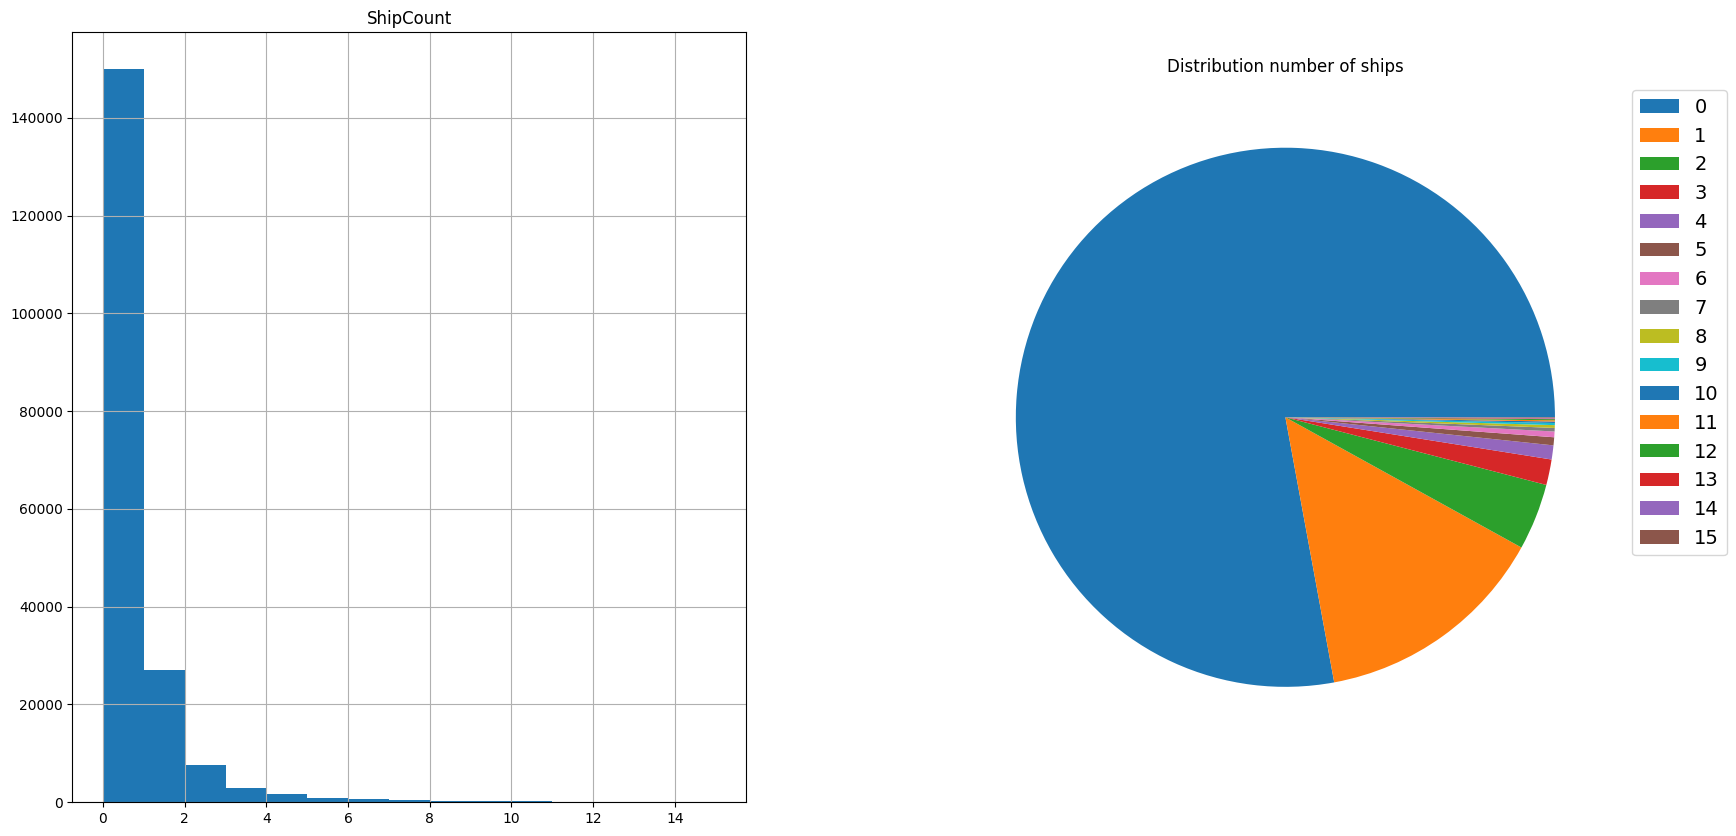

In [60]:
segmentations['ShipCount'] = segmentations.apply(lambda x: 0 if pd.isna(x['EncodedPixels']) else 1, axis=1)
ships_numbers = segmentations[['ImageId','ShipCount']].groupby(['ImageId']).sum()
print(ships_numbers.value_counts())

f,ax=plt.subplots(1, 2,figsize=(20,10))

ships_numbers.hist(bins = 15, ax=ax[0])

y = ships_numbers.value_counts().values
percent = 100.*y/y.sum()
labels = range(0,16)
ships_numbers.value_counts().plot.pie(labels=None, ax=ax[1])
ax[1].legend(labels, bbox_to_anchor=(1., 1.), fontsize=14)
ax[1].yaxis.set_visible(False)
ax[1].set_title('Distribution number of ships')

plt.show()

# Display ship segmentation pixels

In [61]:
def show_image_with_encoded_pixels(image_id: str):
    rows = segmentations[segmentations['ImageId'] == image_id]
    if len(rows) == 0:
        return

    image = get_train_image(image_id)
    image_size, _, _ = image.shape
    ship_count = len(rows)
    all_ships = np.zeros_like(image)

    ax_rows_number = ship_count + 1
    f,ax = plt.subplots(ax_rows_number, 3, figsize=(15, 5 * ax_rows_number))

    for i in range(ship_count):
        image_info = rows.iloc[i]

        encoded_pixels = np.array(image_info['EncodedPixels'].split(), dtype=int)
        pixels, shift = encoded_pixels[::2], encoded_pixels[1::2]
        ship = np.zeros_like(image)

        for pixel, shift in zip(pixels, shift):
            for j in range(shift):
                cur_pixel = pixel + j - 1
                ship[cur_pixel % image_size, cur_pixel // image_size] = [255, 255, 255]
        all_ships += ship

        ax[i, 0].imshow(image)
        ax[i, 1].imshow(ship)
        ax[i, 2].imshow(image * (ship // 255))

    ax[ship_count, 0].imshow(image)
    ax[ship_count, 1].imshow(all_ships)
    ax[ship_count, 2].imshow(image * (all_ships // 255))
    plt.show()

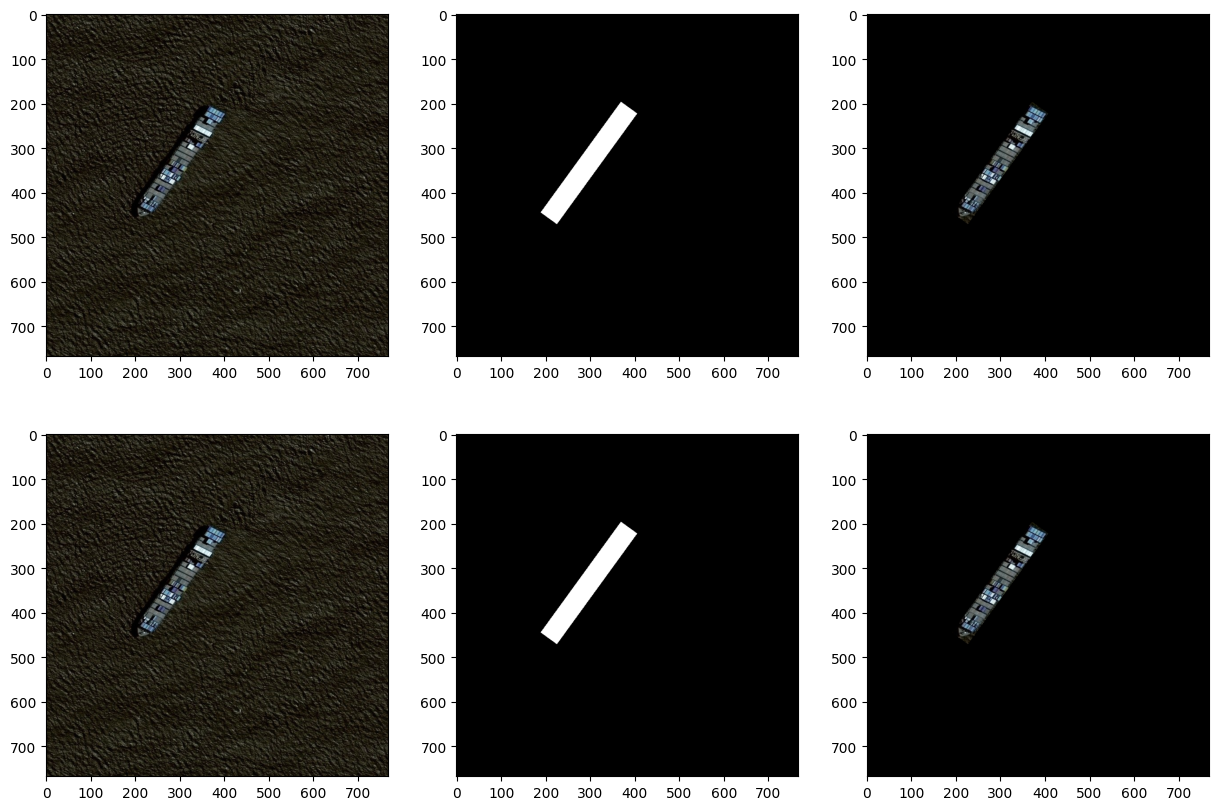

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipCount
32,0006c52e8.jpg,146366 1 147132 4 147899 5 148666 7 149432 10 ...,768,768,1


In [62]:
image_id = '0006c52e8.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

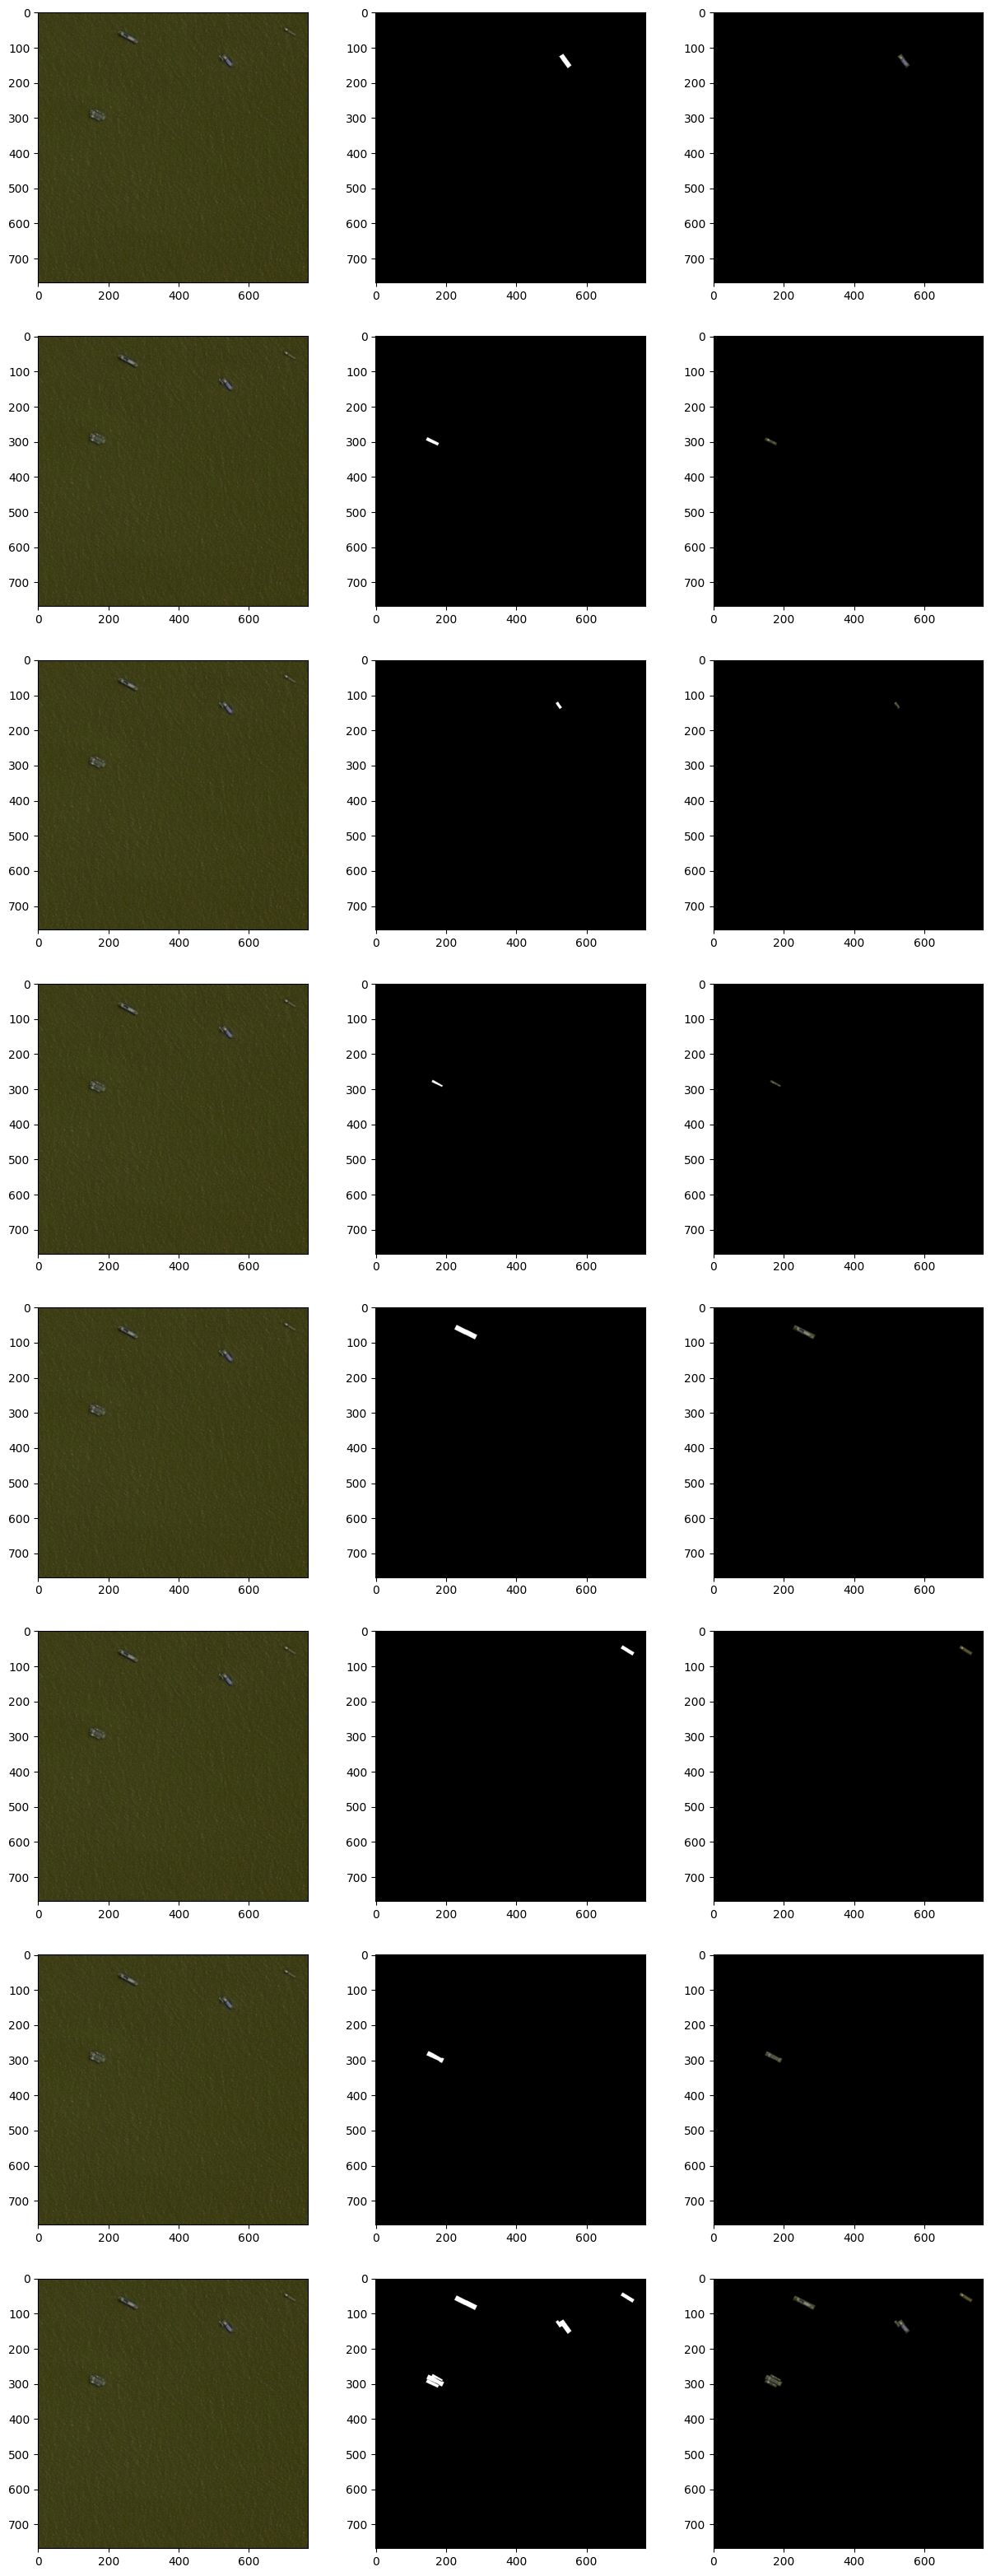

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipCount
60,00113a75c.jpg,401790 1 402557 3 403325 5 404092 7 404859 9 4...,768,768,1
61,00113a75c.jpg,110888 2 111654 4 112420 7 113186 9 113953 11 ...,768,768,1
62,00113a75c.jpg,394109 1 394876 4 395644 5 396411 8 397178 10 ...,768,768,1
63,00113a75c.jpg,123159 1 123925 4 124691 6 125458 8 126227 7 1...,768,768,1
64,00113a75c.jpg,172862 2 173628 4 174394 7 175160 9 175926 12 ...,768,768,1
65,00113a75c.jpg,536114 1 536880 4 537646 6 538413 8 539179 10 ...,768,768,1
66,00113a75c.jpg,111647 1 112413 3 113179 6 113945 8 114711 10 ...,768,768,1


In [63]:
image_id = '00113a75c.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

# Data analysis results

It was found that most of the images (78%) do not contain ships. All the ships in the images take up a very small part (approximately 0,1%), the pictures contain a lot of background. Also, target segmentation for labeled pictures consists of bounding boxes (rectangles). Ships do not intersect, but their borders in some images have adjacent borders.